<a href="https://colab.research.google.com/github/sayakgis/Satellite_image_classification/blob/master/Planet_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Planet: Understanding the Amazon from Space
## Use satellite data to track the human footprint in the Amazon rainforest




### This is a computer vision application of multi label classification problem with satellite images. The dataset is from [Kaggle competetion.](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space)

## Problem Statement:

Every minute, the world loses an area of forest the size of 48 football fields. And deforestation in the Amazon Basin accounts for the largest share, contributing to reduced biodiversity, habitat loss, climate change, and other devastating effects. But better data about the location of deforestation and human encroachment on forests can help governments and local stakeholders respond more quickly and effectively.

Planet, designer and builder of the world’s largest constellation of Earth-imaging satellites, will soon be collecting daily imagery of the entire land surface of the earth at 3-5 meter resolution. While considerable research has been devoted to tracking changes in forests, it typically depends on coarse-resolution imagery from Landsat (30 meter pixels) or MODIS (250 meter pixels). This limits its effectiveness in areas where small-scale deforestation or forest degradation dominate.

Furthermore, these existing methods generally cannot differentiate between human causes of forest loss and natural causes. Higher resolution imagery has already been shown to be exceptionally good at this, but robust methods have not yet been developed for Planet imagery.

In this competition, Planet and its Brazilian partner SCCON are challenging Kagglers to **label satellite image chips with atmospheric conditions and various classes of land cover/land use. **Resulting algorithms will help the global community better understand where, how, and why deforestation happens all over the world - and ultimately how to respond.

<img height="350" width="400" src="https://storage.googleapis.com/kaggle-competitions/kaggle/6322/media/planet.png"></img>

## Project Description:



*  The notebook explains step by step process to **build CNN model that can classify satellite image chips to atomospheric condition and landuse type.**
*   We will use Fastai libraries, Fastai uses Pytorch as a background deep learning framework.

*   I encourge the visitor to read to end of this notebook to gain complete understanding of building world class image classifier using deep learning
*   Special thanks to Jeremy Howard for his awosome training on Fastai



### Installtion FASTAI 0.7.0 and Pytorch 0.2.3 version and configuring Google Colab for FastAI

In [0]:
#This part of the code is required for configuring colab with fastai course version
!pip uninstall fastai  -q
!pip install Pillow==4.1.1  -q
!pip install "fastai==0.7.0"  -q
!pip install torchtext==0.2.3  -q
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python  -q
import cv2 
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag  
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())  
!apt update && apt install -y libsm6 libxext6  -q

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision  -q
import torch
!pip install image -q
!pip install pyunpack -q
!pip install patool  -q

Proceed (y/n)? n
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [83.2 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Release
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 247 kB in 2s (105 kB/s)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
8 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists...
Building depe

In [0]:
# Check python version
import sys
sys.version

'3.6.7 (default, Oct 22 2018, 11:32:17) \n[GCC 8.2.0]'

In [0]:
# Incase need to restart kernel
#!kill -9 -1 

In [0]:
#Automatic reload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Import FastAI Libraries

In [0]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.dataset import *

### Install Kaggle CLI and get the Kaggle Competetion data

In [0]:
#Kaggle CLI
!pip install --upgrade kaggle-cli -q

## Data Description:

The data set is Chip (Image) Data Format, The chips for this competition were derived from Planet's full-frame analytic scene products.

The scenes come from the Amazon basin which includes Brazil, Peru, Uruguay, Colombia, Venezuela, Guyana, Bolivia, and Ecuador (see map below).

<img height="350" width="500" src="https://storage.googleapis.com/kaggle-competitions/kaggle/6322/media/Amazonriverbasin_basemap.png"></img>

### Labeling Process and Data Quality

<img height="350" width="650" src="https://storage.googleapis.com/kaggle-competitions/kaggle/6322/media/chipdesc.jpg"></img>


## Dataloading:
We will download the dataset from Kaggle CLI to Google drive. After data downlaoding small configuration is required:


*  Connect to google drive and create symbolic link in the name of **data**, Unzip the data in folder name called **data**, this is required for using Fastai on dataset

*   Remove the zip files just to create sufficient space on drive

*   Directory structure should be: **data/dataset name/**, inside this train and test folders must be kept

In [0]:
#Downlaod the dataset we will download only the JPEG files

!kg download -u sayakchakraborty -p removed -c 'planet-understanding-the-amazon-from-space' -f 'sample_submission_v2.csv.zip'
!kg download -u sayakchakraborty -p removed -c 'planet-understanding-the-amazon-from-space' -f 'test_v2_file_mapping.csv.zip'
!kg download -u sayakchakraborty -p removed -c 'planet-understanding-the-amazon-from-space' -f 'train_v2.csv.zip'
!kg download -u sayakchakraborty -p removed -c 'planet-understanding-the-amazon-from-space' -f 'test-jpg-additional.tar.7z'
!kg download -u sayakchakraborty -p removed -c 'planet-understanding-the-amazon-from-space' -f 'test-jpg.tar.7z'
!kg download -u sayakchakraborty -p removed -c 'planet-understanding-the-amazon-from-space' -f 'train-jpg.tar.7z'

In [0]:
!pwd    #current working directory

/content


In [0]:
!ls data/planet

__MACOSX  sample_submission_v2.csv  test_v2_file_mapping.csv  train-jpg
models	  test-jpg		    tmp			      train_v2.csv


In [0]:
#Unzip the regular zip files
!mkdir data
!unzip sample_submission_v2.csv.zip -d 'data/planet/'  
!unzip train_v2.csv.zip -d 'data/planet/'  
!unzip test_v2_file_mapping.csv.zip -d 'data/planet/'  

mkdir: cannot create directory ‘data’: File exists
Archive:  sample_submission_v2.csv.zip
replace data/planet/sample_submission_v2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/planet/sample_submission_v2.csv  
replace data/planet/__MACOSX/._sample_submission_v2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/planet/__MACOSX/._sample_submission_v2.csv  
Archive:  train_v2.csv.zip
replace data/planet/train_v2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/planet/train_v2.csv  
replace data/planet/__MACOSX/._train_v2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/planet/__MACOSX/._train_v2.csv  
Archive:  test_v2_file_mapping.csv.zip
replace data/planet/test_v2_file_mapping.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/planet/test_v2_file_mapping.csv  


In [0]:
# Unpack the tar.7z files
from pyunpack import Archive

Archive('test-jpg.tar.7z').extractall('/content')
!tar -xvf test-jpg.tar -C 'data/planet/'    

Archive('train-jpg.tar.7z').extractall('/content')
!tar -xvf train-jpg.tar -C 'data/planet/'   

Archive('test-jpg-additional.tar.7z').extractall('/content')
!tar -xvf test-jpg-additional.tar --directory 'data/planet/test-jpg'   

#move the files from test-jpg-additional to test-jpg folder
!mv data/planet/test-jpg/test-jpg-additional/* data/planet/test-jpg/  

#remove all the zip files from root directory
!rm *  #this will not delete folder so do not worry

**How does the directory look like now?**

In [0]:
# set directory path
PATH='data/planet/'
# list of directories inside path
os.listdir(PATH)

['train_v2.csv',
 'sample_submission_v2.csv',
 'test-jpg',
 'test_v2_file_mapping.csv',
 'train-jpg',
 '__MACOSX',
 'models',
 'tmp']

**Load the labels and explore**

In [0]:
labels=f'{PATH}train_v2.csv'
# Number of records in training data
n=len(list(open(labels)))-1  #Header is counted henece -1
print('Number of training data:',n)

Number of training data: 40479


### Create Validation data
The datset contains training and test data folder and labels in csv file. We would like to create a validation dataset (20%) out of 40479 images, which we shall use for checking the accuracy of the model

In [0]:
val_idx=get_cv_idxs(n)  #20% of the data kept randomly for validation

In [0]:
print('Number of validation data:',len(val_idx))

Number of validation data: 8095


## Data Exploration:

We will explore the data provided in the dog class identification problem

In [0]:
# Check the data folder contains
!ls {PATH}
#shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

__MACOSX  sample_submission_v2.csv  test_v2_file_mapping.csv  train-jpg
models	  test-jpg		    tmp			      train_v2.csv


**Populate the labels in a dataframe**

In [0]:
df=pd.read_csv(labels)
df.sample(10)

,image_name,tags
14187,train_14187,partly_cloudy primary
29086,train_29086,agriculture partly_cloudy primary road
27928,train_27928,agriculture clear primary road
3561,train_3561,haze water
8700,train_8700,clear primary
20348,train_20348,agriculture cultivation partly_cloudy primary
23501,train_23501,agriculture clear cultivation primary
33994,train_33994,bare_ground clear primary
25028,train_25028,clear primary
24649,train_24649,cloudy


**Observations**: The dataframe contains image_name and tags field, the image_name column has file name of the images. But file name does not have suffix of file type like** .jpg**


More over this is a ** multilabel & multiclass classification** problem, i.e for each image multiple labels are available of landuse type, weather etc. Hence at last layer we can not use softmax instead we will use sigmoid function.

**How many type of classes are there in the dataset?**

In [0]:
df_class=df.groupby('tags').count().sort_values('image_name',ascending=False)
print('Number of class types in dataset:',len(df_class))
df_class

Number of class types in dataset: 449


,image_name
tags,
clear primary,13636
partly_cloudy primary,3630
cloudy,2089
clear primary water,1850
agriculture clear primary road,1680
agriculture clear primary,1626
haze primary,1471
agriculture clear cultivation primary,1170
agriculture clear habitation primary road,1125


**Observation:**

-There are 449 classs available in this training data set.

**Let us see the dataset images and the classs types**

In [0]:
#take 10 files
files=os.listdir(f'{PATH}train-jpg')[:10]
print(files)

['train_17552.jpg', 'train_21158.jpg', 'train_26200.jpg', 'train_37226.jpg', 'train_28540.jpg', 'train_5018.jpg', 'train_4850.jpg', 'train_6957.jpg', 'train_5282.jpg', 'train_37377.jpg']


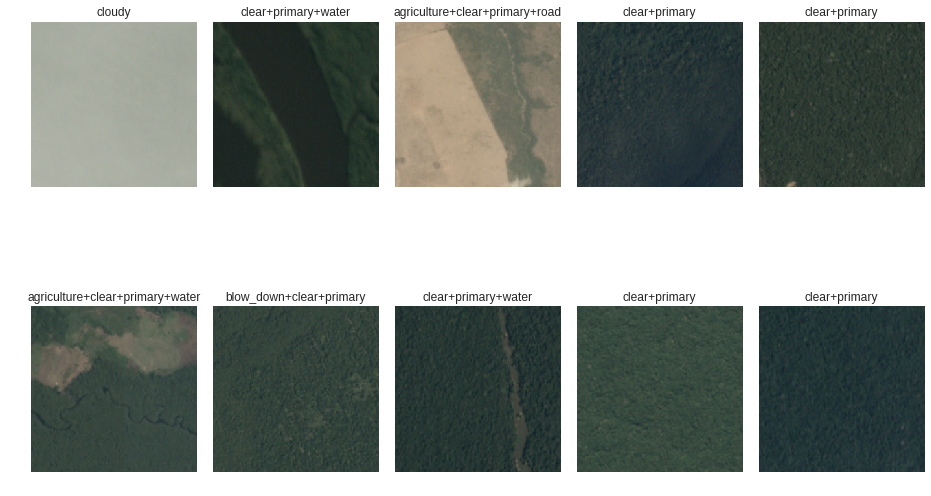

In [0]:
#Let us open 10 images and see their labels
plt.figure(figsize=(16,10))
plt.subplots_adjust(hspace=0.1,wspace=0.1)
for i,j in enumerate(files):
  plt.subplot(2,5,(i+1))
  f=plt.imread(PATH+'train-jpg/'+files[i])
  plt.imshow(f)
  plt.axis("Off")
  plt.title('+'.join(str(list(df.loc[df.image_name==files[i][:-4]]['tags']))[2:-2].split()))

In [0]:
img_1=PIL.Image.open(PATH+'train-jpg/'+files[9])
img_1.size

(256, 256)

**Set basics parameters like size of image, batch size and predefined models**
 
**We will use* Resnet34* to start with**

In [0]:
arch=resnet34    # we will use resnet34 model as our architechure

**Let us create the data object for Fastai**


1.   We will create data with data augmentation: In Fastai library brightness and contrasts are automatically randomised.
2.   For data augmentation we are chossing side on flipping and with zoom of 1.1




In [0]:
#Transformation for training data set with side on and zoom 1.05
tfms=tfms_from_model(arch,256,aug_tfms=transforms_top_down,max_zoom=1.05)

#Data object, here the labels are stored in csv so we shall use from_csv function
data=ImageClassifierData.from_csv(path=PATH,              #location of the data
                                  folder='train-jpg',         #training dataset location
                                  csv_fname=labels,       #loading the labels from csv
                                  tfms=tfms,              #using transforms defined early
                                  val_idxs=val_idx,       #validation dataset of 20% defined early
                                  test_name='test-jpg',       #test folder name as we shall submit the data to kaggle
                                  bs=58,                  #batch size
                                  suffix='.jpg')          #the labels in the csv does not have file extention so we are passing this suffix

**Let us check if we can fetch the imges from data object**

In [0]:
fn=PATH+data.trn_ds.fnames[0]
fn

'data/planet/train-jpg/train_0.jpg'

**Let us try to understand the size distribution of the images in the training dataset**

Create a dictonary for size of image images

In [0]:
size_d={k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

Create ndarray of row and column size of images

In [0]:
row_sz,col_sz=list(zip(*size_d.values()))
row_sz=np.array(row_sz)
col_sz=np.array(col_sz)

Check values of row and col sizes

In [0]:
row_sz[:5]

array([256, 256, 256, 256, 256])

In [0]:
col_sz[:5]

array([256, 256, 256, 256, 256])

**Plot histogram to understand distribution of row and column size of images**

**Row size**

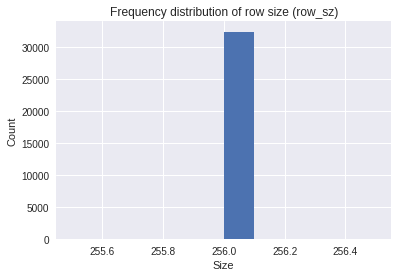

In [0]:
plt.hist(row_sz)
plt.title('Frequency distribution of row size (row_sz)')
plt.xlabel('Size');plt.ylabel('Count')
plt.show()

**Column size**

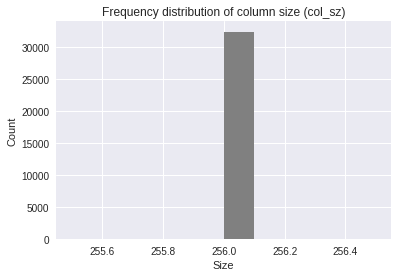

In [0]:
plt.hist(col_sz,color='gray')
plt.title('Frequency distribution of column size (col_sz)')
plt.xlabel('Size');plt.ylabel('Count')
plt.show()

**Observation:**
The best part is all the images are of 256*256 rows and columns


**How many images are there in train and test data**

In [0]:
print('No of images in training data:',len(data.trn_ds))
print('No of images in test data:',len(data.test_ds))
print('No of images in validation set:',len(val_idx))
print('No of classes in training data:',len(data.classes))

No of images in training data: 32384
No of images in test data: 61191
No of images in validation set: 8095
No of classes in training data: 17


In [0]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

## Build initial model (Resnet34 as architechture)

**Let us create a function to resize the and get the data, this function will be used to pass size as parameters**

In [0]:
def get_data(sz):  #sz: image size, bs: batch size
  tfms=tfms_from_model(arch,sz,aug_tfms=transforms_top_down,max_zoom=1.1)
  return ImageClassifierData.from_csv(PATH,'train-jpg',csv_fname=labels,bs=58,tfms=tfms,val_idxs=val_idx,suffix='.jpg',test_name='test-jpg')  

In [0]:
#Resize the data 256
data=get_data(256)

In [0]:
#Get features and labels from validation data
x,y=next(iter(data.val_dl))

#### Let us check image and their labels how it is organised

[('agriculture', 0.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 0.0)]

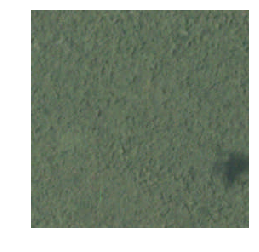

In [0]:
#plt.imshow(x[0])
plt.imshow(data.val_ds.denorm(to_np(x))[25]*1.6)
plt.axis('Off')
list(zip(data.classes,y[25]))

#### Define metric f2 function as asked by Kaggle competetion

In [0]:
from sklearn.metrics import fbeta_score
import warnings

def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

### At first train the model to image size 64

In [0]:
sz=64
metrics=[f2]
data=get_data(sz)

In [0]:
learn=ConvLearner.pretrained(arch,data,metrics=metrics)    #we will not use precomputed weights as this dataset is completely different from imagenet data

**Learning rate finder**

With this operation we will try to find the optimum learning rate required for convergence while optimisation loss function

In [0]:
lrf=learn.lr_find()

epoch      trn_loss   val_loss   f2         
    0      0.227353   0.39784    0.827482  



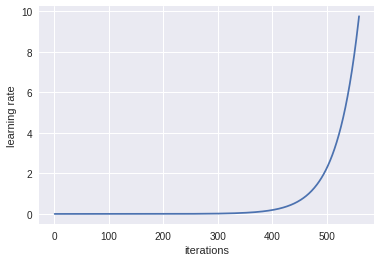

In [0]:
learn.sched.plot_lr()

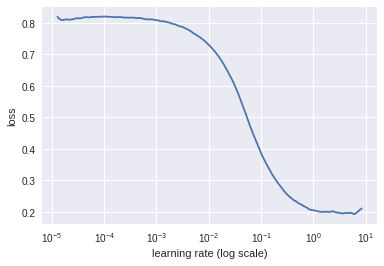

In [0]:
learn.sched.plot()

**Observation:**

This shows for satellite images learning rate is really high, we will got for 0.2 as learning rate to fit the model

In [0]:
lr=0.2

**Fit the model**

We will use stochastic gradient deccent with restart concept, cycle_len=1 and cycle_mult=2

In [0]:
% time learn.fit(lr,3,cycle_len=1,cycle_mult=2)  

epoch      trn_loss   val_loss   f2         
    0      0.149575   0.131805   0.885518  
    1      0.139253   0.126835   0.890074  
    2      0.135245   0.124205   0.892266  
    3      0.13611    0.123436   0.89276   
    4      0.132657   0.122036   0.895133  
    5      0.129882   0.12061    0.895448  
    6      0.129999   0.12142    0.894816  

CPU times: user 20min 16s, sys: 2min 7s, total: 22min 24s
Wall time: 13min 6s


[array([0.12142]), 0.8948159826539334]

**Observation:**

To start with we are getting 89% validation accuracy which looks a good starting point for 17 class multilabel dataset

The val_loss and trn_loss are very close, that means there is no problem of overfitting or underfitting

Text(0.5,1,'Stochastic GD with restart')

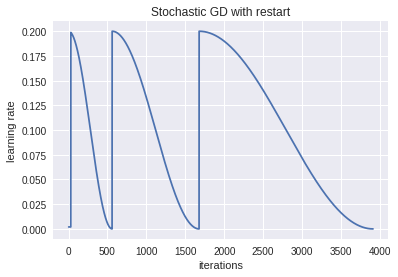

In [0]:
learn.sched.plot_lr()
plt.title('Stochastic GD with restart')

#### Let us now unfreeze the layers and apply differential learning rate to different layers and fit the model

In [0]:
lrs=np.array([lr/9,lr/3,lr])

In [0]:
learn.unfreeze()

In [0]:
% time learn.fit(lrs,3,cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2         
    0      0.118283   0.104816   0.912797  
    1      0.110861   0.100465   0.915796  
    2      0.103235   0.097966   0.919881  
    3      0.105788   0.09917    0.918662  
    4      0.100502   0.095777   0.920254  
    5      0.100533   0.095566   0.919349  
    6      0.09631    0.094911   0.919805  

CPU times: user 23min 44s, sys: 3min 42s, total: 27min 26s
Wall time: 17min 52s


[array([0.09491]), 0.9198045462287873]

In [0]:
#create directory for model
os.makedirs(f'{PATH}models',exist_ok=True)

In [0]:
!ls {PATH}

__MACOSX  sample_submission_v2.csv  test_v2_file_mapping.csv  train-jpg
models	  test-jpg		    tmp			      train_v2.csv


#### Save the model with 64

In [0]:
learn.save(f'{sz}')

In [0]:
!ls {PATH}'models'

64.h5  tmp.h5


#### See the loss plot

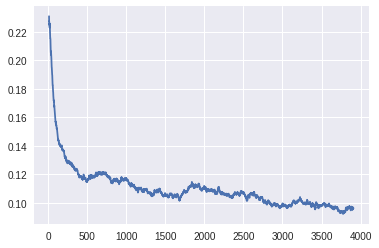

In [0]:
learn.sched.plot_loss()

### Increase the image size to 128 and fit the model

In [0]:
sz=128

In [0]:
learn.set_data(get_data(sz))   #set the model to 128 size

In [0]:
learn.freeze()   #freeze the layers

In [0]:
%time learn.fit(lr,3,cycle_len=1,cycle_mult=2)  #fit the model

epoch      trn_loss   val_loss   f2         
    0      0.096199   0.094891   0.918571  
    1      0.097749   0.0941     0.918681  
    2      0.096592   0.093461   0.91911   
    3      0.096363   0.09472    0.916572  
    4      0.095742   0.093139   0.918865  
    5      0.096453   0.09215    0.920588  
    6      0.093633   0.091874   0.9211    

CPU times: user 27min 38s, sys: 3min 12s, total: 30min 50s
Wall time: 18min 28s


[array([0.09187]), 0.9211001104832424]

#### Apply differntial learning rate and fit

In [0]:
learn.unfreeze()

In [0]:
% time learn.fit(lrs,3,cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss   f2         
    0      0.096353   0.087879   0.92619   
    1      0.094644   0.088711   0.924529  
    2      0.087948   0.086473   0.92821   
    3      0.094199   0.088513   0.92604   
    4      0.087871   0.086833   0.927247  
    5      0.084498   0.085131   0.929238  
    6      0.087838   0.085653   0.929074  

CPU times: user 41min 53s, sys: 9min 30s, total: 51min 23s
Wall time: 38min 49s


[array([0.08565]), 0.9290735076164249]

### Increase the image size to 256 and train the Resnet

In [0]:
sz=256

In [0]:
learn.set_data(get_data(sz))

In [0]:
learn.freeze()

In [0]:
% time learn.fit(lr,3,cycle_len=1,cycle_mult=2)  #fit the model

epoch      trn_loss   val_loss   f2         
    0      0.09065    0.090259   0.92458   
    1      0.092541   0.088789   0.925988  
    2      0.089108   0.089372   0.924867  
    3      0.0922     0.088025   0.927219  
    4      0.088859   0.087839   0.92698   
    5      0.090834   0.087455   0.927497  
    6      0.085774   0.087004   0.927807  

CPU times: user 59min 30s, sys: 12min 24s, total: 1h 11min 55s
Wall time: 49min 40s


[array([0.087]), 0.927806577960665]

#### Apply differential learning rate

In [0]:
learn.unfreeze()

In [0]:
% time learn.fit(lrs,3,cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss   f2         
    0      0.087925   0.084371   0.929623  
    1      0.086256   0.084063   0.931388  
    2      0.082356   0.082586   0.932505  
    3      0.087257   0.084043   0.930341  
    4      0.084756   0.084363   0.92888   
    5      0.080399   0.082057   0.931172  
    6      0.080103   0.08141    0.932361  

CPU times: user 1h 45min 39s, sys: 37min 38s, total: 2h 23min 18s
Wall time: 2h 51s


[array([0.08141]), 0.9323609784389779]

**How did stochastics gradient descent with restart is working**

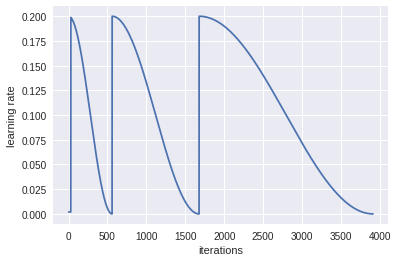

In [0]:
learn.sched.plot_lr()

**Save the model**


In [0]:
learn.save(f'{sz}')

Download the model to local system

In [0]:
from google.colab import files
files.download(f'{PATH}models/256.h5')

**Test time augmentation on validation dataset**

In [0]:
multi_pred, y=learn.TTA()

In [0]:
pred=np.mean(multi_pred,0)

**Check f2 score on validation data**

In [0]:
f2(pred,y)

0.9304349622600833

## Conclusion:

We have created a image classifier now with 93% f2 score. The speciallity of this classifier is it is multilabel and multi class classifier. This is for public leader board.

I will create a private submission on competetion using the following concepts:


*   Will remove the validation set and retrain the model and then perform prediction on test data, this is to ensure that model sees through the all the images of train data provided by kaggle
*   Will try to apply other models like inception etc for improvement of accuracy

Thanks for reading till here! Hope you have enjoyed!

